In [ ]:
from google.colab  import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/MyDrive/NBAC5/real time (1).zip'

Archive:  /content/drive/MyDrive/NBAC5/real time (1).zip
   creating: real time/
   creating: real time/test/
   creating: real time/test/eating animal/
  inflating: real time/test/eating animal/16 (1).jpeg  
  inflating: real time/test/eating animal/16 (10).jpg  
  inflating: real time/test/eating animal/16 (100).jpg  
  inflating: real time/test/eating animal/16 (101).jpg  
  inflating: real time/test/eating animal/16 (102).jpg  
  inflating: real time/test/eating animal/16 (103).jpg  
  inflating: real time/test/eating animal/16 (104).jpg  
  inflating: real time/test/eating animal/16 (105).jpg  
  inflating: real time/test/eating animal/16 (106).jpg  
  inflating: real time/test/eating animal/16 (107).jpg  
  inflating: real time/test/eating animal/16 (108).jpg  
  inflating: real time/test/eating animal/16 (109).jpg  
  inflating: real time/test/eating animal/16 (11).jpg  
  inflating: real time/test/eating animal/16 (110).jpg  
  inflating: real time/test/eating animal/16 (111).j

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model
from keras.applications import DenseNet201
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
class_names = ['eating animal', 'sitting animal', 'standing animal']
nb_classes = len(class_names)
image_size = (150,150)

In [ ]:
def load_data():

    datasets = ['/content/real time/train','/content/real time/test' ]
    images = []
    labels = []

    # iterate through training and test sets
    for dataset in datasets:

        # iterate through folders in each dataset
        for folder in os.listdir(dataset):

            if folder in ['eating animal']: label = 0
            elif folder in ['sitting animal']: label = 1
            elif folder in ['standing animal']: label = 2
            #elif folder in ['NEUTROPHIL']: label = 3

            # iterate through each image in folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # get pathname of each image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the| img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, image_size)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

In [ ]:
images, labels = load_data()

100%|██████████| 300/300 [01:07<00:00,  4.44it/s]


In [ ]:
images, labels = shuffle(images, labels, random_state=5)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

In [ ]:
### Model number 3: finetuned VGG16 model.

from keras.applications import VGG16

vgg16_model = VGG16(
    include_top = False,
    weights = 'imagenet',
    input_tensor = None,
    input_shape = (150,150,3),
    pooling = None
)

# 3 fully connected layers are added, with 256, 128 and 64 units respectively
# Dropout and Batch Normalization are performed on the full connected layers.
# Option here to train on the final block in the VGG15 model ("True") or use imagenet weights for this layer ("False")


vgg16_model.trainable = True

for layer in vgg16_model.layers:
  if 'block5' in layer.name:
    layer.trainable = False
  else:
    layer.trainable = False

input = Input(shape = (150,150,3))

layer = vgg16_model(inputs=input)
layer = Flatten()(layer)
layer = BatchNormalization()(layer)
layer = Dense(units=256, activation='relu')(layer)
layer = Dropout(0.7)(layer)
layer = BatchNormalization()(layer)
layer = Dense(units=128, activation='relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(units=64, activation='relu')(layer)
layer = Dropout(0.3)(layer)
layer = Dense(units=3,activation='softmax')(layer)

model3 = Model(inputs=input, outputs=layer)

model3.summary()

model3.compile(loss='sparse_categorical_crossentropy',
            optimizer= 'adam',
            metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 2,
    verbose = 1,
    factor = 0.3,
    min_lr = 0.000001)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_96 (Ba  (None, 8192)              32768     
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                           

In [ ]:
history3 = model3.fit(
    train_images,
    train_labels,
    batch_size = 32,
    epochs = 5,
    validation_data = (val_images, val_labels),
    callbacks=[learning_rate_reduction])

Epoch 1/5
72/72 [==============================] - 628s 9s/step - loss: 0.7744 - accuracy: 0.6786 - val_loss: 0.2294 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 2/5
72/72 [==============================] - 636s 9s/step - loss: 0.3646 - accuracy: 0.8541 - val_loss: 0.2044 - val_accuracy: 0.9271 - lr: 0.0010
Epoch 3/5
72/72 [==============================] - 619s 9s/step - loss: 0.2939 - accuracy: 0.8937 - val_loss: 0.1929 - val_accuracy: 0.9132 - lr: 0.0010
Epoch 4/5
72/72 [==============================] - ETA: 0s - loss: 0.2282 - accuracy: 0.9129
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
72/72 [==============================] - 615s 9s/step - loss: 0.2282 - accuracy: 0.9129 - val_loss: 0.1895 - val_accuracy: 0.9236 - lr: 0.0010
Epoch 5/5
72/72 [==============================] - 619s 9s/step - loss: 0.2121 - accuracy: 0.9190 - val_loss: 0.1937 - val_accuracy: 0.9201 - lr: 3.0000e-04


In [ ]:
# Evaluating the model on the test data

results = model3.evaluate(test_images, test_labels)

print("Loss of the model is - ", results[0])
print("Accuracy of the model is - ", results[1]*100, "%")

9/9 [==============================] - 69s 7s/step - loss: 0.2161 - accuracy: 0.9059
Loss of the model is -  0.21607933938503265
Accuracy of the model is -  90.59233665466309 %


In [ ]:
model3.save('Bloodcell_Classification_Model2_Finetuned_VGG16_30_epochs.h5')

In [ ]:
# Create predictions for test images

predictions3 = model3.predict(test_images)
predictions3 = np.argmax(predictions3,axis=1)
predictions3[:15]

9/9 [==============================] - 69s 8s/step


array([2, 2, 2, 0, 2, 0, 2, 0, 1, 2, 1, 2, 2, 0, 2])

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    test_labels,
    predictions3,
    target_names = ['eating animal (Class 0)', 'sitting animal (Class 1)', 'standing animal (Class 2)']))

                           precision    recall  f1-score   support

  eating animal (Class 0)       0.95      0.92      0.93       109
 sitting animal (Class 1)       0.74      0.88      0.80        49
standing animal (Class 2)       0.94      0.91      0.92       129

                 accuracy                           0.91       287
                macro avg       0.88      0.90      0.89       287
             weighted avg       0.91      0.91      0.91       287



In [ ]:
# Confusion matrix plot function and execute

def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm,
        cmap = 'Blues',
        linecolor = 'black',
        linewidth = 1,
        annot = True,
        fmt = '',
        xticklabels = class_names,
        yticklabels = class_names)

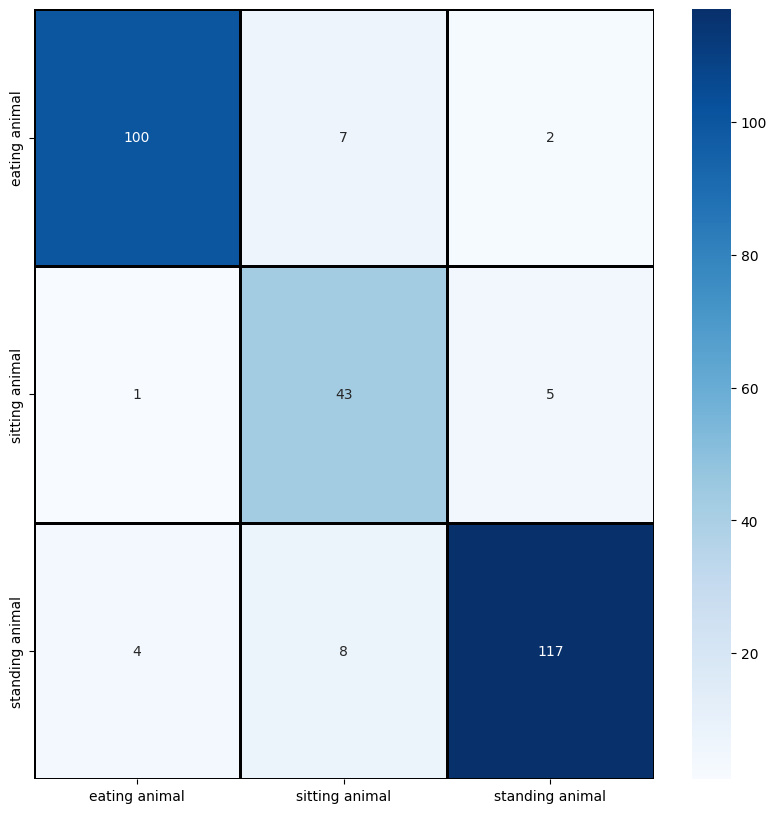

In [ ]:
# Plot confusion matrix for Model 3

cm3 = confusion_matrix(test_labels, predictions3)
cm3 = pd.DataFrame(cm3, index = ['0', '1', '2' ], columns = ['0', '1', '2' ])
plot_confusion_matrix(cm3)